# Basic Usage

## Evaluation

In [1]:
from eval_gnn import eval_gnn
from str2env import str2env

/home/wenjin/anaconda3/envs/gnnmp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: May 20 2022 19:44:17


In [6]:
# check maze environment
env, indexes = str2env('maze2easy')  # choose env among ('maze2easy', 'maze2hard', 'kuka7', 'ur5', 'snake7', 'kuka13', 'kuka14')
print(len(env.maps))
print(len(env.init_states))

print(env.init_states[0])
_ = env.init_new_problem()
# print(env.map)
# print("obstacles", env.obstacles)
# print(env._transform((0.86666667, 0.86666667)))



%matplotlib inline
import matplotlib.pyplot as plt
from utils.plot import plot_edges, plot_env_only, plot_optimization_edges

# perform 10 random obstacles movement
for i in range(10):
    plot_env_only(env.get_problem(), env, save="./debug_files/{}.png".format(i), title="step:{}".format(i+1))
    env.moving_once(env.get_problem())

3000
3000
[-0.85735603  0.57040995]


In [2]:
# evaluation on the test cases
env, indexes = str2env('maze2easy')  # choose env among ('maze2easy', 'maze2hard', 'kuka7', 'ur5', 'snake7', 'kuka13', 'kuka14')
# evaluation with GNN
_ = eval_gnn(str(env), 1234, env=env, indexes=indexes, smooth=True, use_tqdm=True)

gnn 0.02s, search 0.05s, explored 6: 100%|██████████| 1000/1000 [02:22<00:00,  7.03it/s] 

success rate: 1000
collision check: 1364.40
collision check explore: 1244.76
running time: 0.14
path cost: 1.22
total time: 140.57
total time explore: 123.86



# Advanced

## Generate New Dataset

In [2]:
from diversify_maze import find_mazes, INFINITY
import numpy as np
# generate 1000 test cases
maps, init_states, goal_states = find_mazes(10, density=[100, 150], dist2goal_threshold=1)
np.savez('maze_files/mazes_new_dataset.npz', maps=maps, goal_states=goal_states, init_states=init_states)

len of new data: 9:   0%|          | 45/10000000 [00:00<24:12:32, 114.74it/s]


## Test on New Environment

In [12]:
from tqdm import tqdm
from config import set_random_seed
from str2name import str2name
import torch
from eval_gnn import explore

from environment import MazeEnv
env = MazeEnv(dim=2, map_file='maze_files/mazes_new_dataset.npz')
indexes = range(0, 1000)
bs = 100  # only sample 100 points
results = []

_, model, model_path, model_s, model_s_path = str2name(str(env))
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model_s.load_state_dict(torch.load(model_s_path, map_location=torch.device("cpu")))
model.eval()
model_s.eval()

for i in tqdm(range(10)):
    
    env.init_new_problem(i)
    set_random_seed(1234)
    _, model, model_path, model_s, model_s_path = str2name(str(env))
    result = explore(env, model, model_s, smooth=True, smoother='oracle', batch=bs, t_max=bs, k=10) 
    
    results.append(result)

100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


In [29]:
print(type(results[0]))
one_solution = results[1]

for key in one_solution:
    print(key)

print(one_solution["smooth_path"])


<class 'dict'>
c_explore
c_smooth
data
explored
forward
total
total_explore
success
t0
path
smooth_path
explored_edges
[array([0.5767744, 0.7837667], dtype=float32), (0.7691946408097953, 0.7297078215371327), (0.7854325534910956, 0.6312934591105511), (0.7874313884933974, 0.6094406661791287), (0.7767580115767073, 0.4536586071754781), (0.7730949925963325, 0.3417057007071739), (0.7928280050198152, 0.2988070977483578), (0.7934223824036832, 0.20885660800164263), array([0.76667154, 0.13827716], dtype=float32), (0.7615094057743671, 0.08847791785281174), (0.7382452881699406, -0.17993769044323465), (0.5867991603090158, -0.3501830183053238), (0.569757362417953, -0.4823899332450175), (0.5043011436161883, -0.7018887746112332), (0.3850087291911096, -0.7730420502530156), (0.2348705206961705, -0.781864244470943), (0.014579957273636368, -0.7202538065140223), (-0.04455654248103132, -0.5703811707415128), (-0.04581360137258846, -0.27498929350036627), (-0.04252366931674686, -0.0709284846526562), (-0.188231

In [13]:
# get the collision numbers
c_explores = [r['c_explore'] for r in results]

<Figure size 640x480 with 0 Axes>

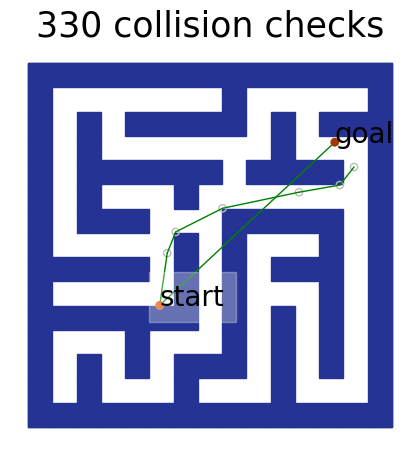

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.plot import plot_edges
i = np.argmin(c_explores)
env.init_new_problem(i)
edges = results[i]['data'].v[ np.array(results[i]['explored_edges']).reshape(-1) ].reshape(-1, 2, 2)
edges = [[tuple(k), tuple(v)] for k, v in zip(edges[:, 0, :].cpu().numpy(), edges[:, 1, :].cpu().numpy())]
plot_optimization_edges(results[i]['smooth_path'], edges, env.get_problem(), \
           title='{0:d} collision checks'.format(results[i]['c_explore']), \
           save=None)
plt.show()

In [25]:
print(np.array(results[i]['explored_edges']).reshape(-1))
print(results[i]['data'].v[np.array(results[i]['explored_edges']).reshape(-1)])

[  0   0   0  98  98   0  98  16  16  98  16  62  62  16  62  57  57  62
  57  97  97  57  57  37  37  57  97   5   5  97  57   5   5  57  57  31
  31  57  97   8   8  97  97  70  70  97  70   8   8  70  70  91  91  70
  91   8   8  91  91  23  23  91  70  36  36  70  70  46  46  70  46   8
   8  46  46  22  22  46  70  22  22  70  46  71  71  46  71   8   8  71
   8  22  22   8  22  81  81  22  23  53  53  23  22  85  85  22  85  96
  96  85  37 100 100  37  96  32  32  96  85  32  32  85  23  77  77  23
  81  32  32  81  32  27  27  32  27   1   1  27]
tensor([[-0.2937,  0.8065],
        [-0.2937,  0.8065],
        [-0.2937,  0.8065],
        [-0.0533,  0.8051],
        [-0.0533,  0.8051],
        [-0.2937,  0.8065],
        [-0.0533,  0.8051],
        [ 0.2349,  0.8242],
        [ 0.2349,  0.8242],
        [-0.0533,  0.8051],
        [ 0.2349,  0.8242],
        [ 0.5114,  0.8642],
        [ 0.5114,  0.8642],
        [ 0.2349,  0.8242],
        [ 0.5114,  0.8642],
        [ 0.8438,  

{'c_explore': 939, 'c_smooth': 3555, 'data': Data(goal=[2], v=[202, 2], labels=[202, 3], edge_index=[2, 3094]), 'explored': [0, 67, 57, 11, 73, 62, 28, 52, 48, 90, 95, 27, 98, 10, 65, 58, 21, 32, 38, 80, 74, 60, 7, 76, 89, 22, 31, 43, 17, 92, 68, 24, 86, 56, 91, 97, 25, 13, 3, 94, 46, 55, 35, 23, 37, 59, 14, 84, 64, 54, 12, 20, 77, 36, 33, 81, 2, 51, 100, 63, 44, 41, 72, 30, 99, 40, 69, 42, 19, 93, 1], 'forward': 0.00754237174987793, 'total': 0.24811625480651855, 'total_explore': 0.12772226333618164, 'success': True, 't0': 1668218466.894259, 'path': [array([-0.52021235,  0.2539841 ], dtype=float32), array([-0.48666912,  0.39940652], dtype=float32), array([-0.5192349 ,  0.57585555], dtype=float32), array([-0.20559484,  0.5774603 ], dtype=float32), array([0.07341205, 0.54647744], dtype=float32), array([-0.05334025,  0.80511004], dtype=float32), array([-0.3538106,  0.7428465], dtype=float32), array([-0.8250568 ,  0.77393186], dtype=float32), array([-0.85417956,  0.30167815], dtype=float32

<Figure size 640x480 with 0 Axes>

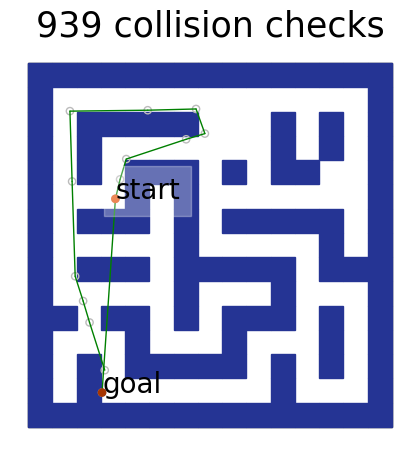

In [15]:
i = np.argmax(c_explores)
env.init_new_problem(i)
edges = results[i]['data'].v[np.array(results[i]['explored_edges']).reshape(-1)].reshape(-1, 2, 2)
edges = [[tuple(k), tuple(v)] for k, v in zip(edges[:, 0, :].cpu().numpy(), edges[:, 1, :].cpu().numpy())]
# print(results[i])
# print(results[i]['smooth_path'])
plot_optimization_edges(results[i]['smooth_path'], edges, env.get_problem(), \
           title='{0:d} collision checks'.format(results[i]['c_explore']), \
           save=None)
plt.show()